## 1. Import libraries

In [212]:
import numpy as np
import pandas as pd

import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import matplotlib. dates as mandates

import tensorflow as tf
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn. preprocessing import MinMaxScaler

import pandas_datareader.data as web

import pandas_ta as ta


import warnings
warnings.filterwarnings("ignore")

## 2. Import financial data

In [213]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()

gold_df = web.DataReader("GC=F", 'yahoo', start, end)

gold_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0.0,273.899994
2000-08-31,278.299988,274.799988,274.799988,278.299988,0.0,278.299988
2000-09-01,277.000000,277.000000,277.000000,277.000000,0.0,277.000000
2000-09-05,275.799988,275.799988,275.799988,275.799988,2.0,275.799988
2000-09-06,274.200012,274.200012,274.200012,274.200012,0.0,274.200012
...,...,...,...,...,...,...
2022-12-12,1793.900024,1777.699951,1787.300049,1780.500000,85.0,1780.500000
2022-12-13,1819.800049,1780.500000,1780.699951,1813.900024,205.0,1813.900024
2022-12-14,1812.800049,1797.900024,1810.800049,1807.500000,1074.0,1807.500000


In [214]:
gold_df=gold_df.drop(['Close','Low','High','Open','Volume'],axis = 1)

gold_df

,Adj Close
Date,
2000-08-30,273.899994
2000-08-31,278.299988
2000-09-01,277.000000
2000-09-05,275.799988
2000-09-06,274.200012
...,...
2022-12-12,1780.500000
2022-12-13,1813.900024
2022-12-14,1807.500000


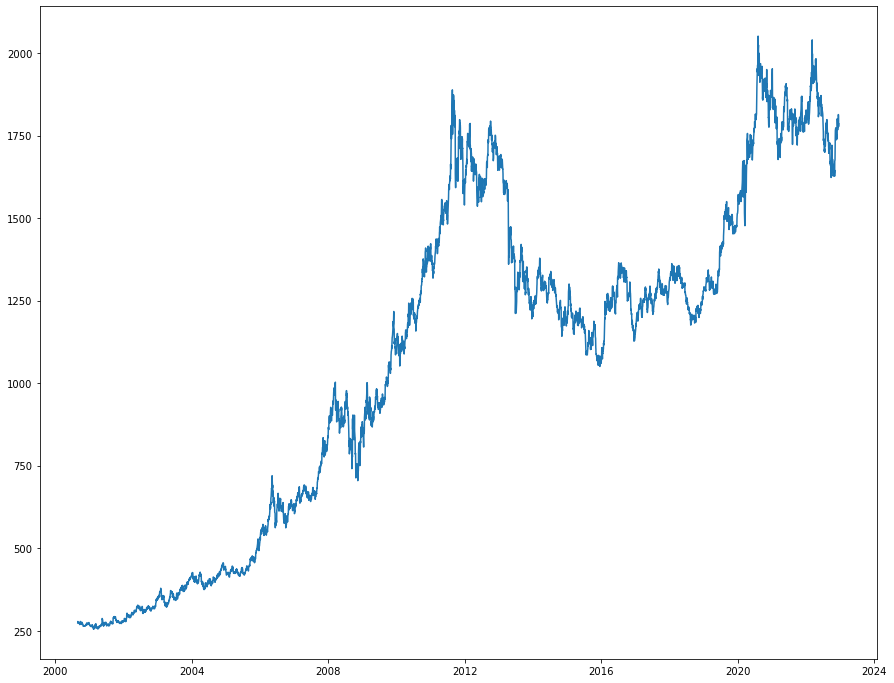

In [215]:
plt.figure(figsize=(15,12))


plt.plot(gold_df['Adj Close'])

## will use the last 10 days price action to predict the next day

In [216]:
#This is basicvally a function to split our x and y axes and to creat time series dataframe 
#where we essentially look back 5 to predict 6
#Y will be our target variable here
# [[[1], [2], [3], [4], [5]]] [6]
#Source Greg Hogg https://www.youtube.com/watch?v=c0k-YLQGKjY


def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
        
    return np.array(X), np.array(y)

In [217]:
adj_close = gold_df['Adj Close']
WINDOW_SIZE = 10
X1, y1 = df_to_X_y(adj_close, WINDOW_SIZE)
X1.shape, y1.shape

((5586, 10, 1), (5586,))

In [218]:
##This is somewhat of an arbitrary/hearistic split between training,testing,validation segments of the time series
#We have 5595 rows and will split roughly 80:10:10 

X_train1, y_train1 = X1[:4469], y1[:4469]
X_val1, y_val1 = X1[4469:5027],y1[4469:5027]
X_test1,y_test1 = X1[5027:], y1[5027:]
 
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4469, 10, 1), (4469,), (558, 10, 1), (558,), (559, 10, 1), (559,))

In [219]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [220]:
model1 = Sequential()
model1.add(LSTM(100, return_sequences=True, input_shape=(X_train1.shape[1], 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 10, 100)           40800     
                                                                 
 lstm_17 (LSTM)              (None, 64)                42240     
                                                                 
 dense_10 (Dense)            (None, 8)                 520       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 83,569
Trainable params: 83,569
Non-trainable params: 0
_________________________________________________________________


In [221]:
model1.compile(loss= 'mean_squared_error', optimizer='adam')

model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1),epochs=100, batch_size=16)

Epoch 1/100
280/280 [==============================] - 9s 16ms/step - loss: 1012029.4375 - val_loss: 2012115.0000
Epoch 2/100
280/280 [==============================] - 4s 14ms/step - loss: 850426.7500 - val_loss: 1683350.1250
Epoch 3/100
280/280 [==============================] - 4s 15ms/step - loss: 640958.3750 - val_loss: 1293354.1250
Epoch 4/100
280/280 [==============================] - 4s 15ms/step - loss: 444768.2188 - val_loss: 928120.0000
Epoch 5/100
280/280 [==============================] - 4s 15ms/step - loss: 308959.0312 - val_loss: 656232.3125
Epoch 6/100
280/280 [==============================] - 4s 13ms/step - loss: 240614.5625 - val_loss: 487226.0312
Epoch 7/100
280/280 [==============================] - 4s 13ms/step - loss: 150197.2500 - val_loss: 307786.3750
Epoch 8/100
280/280 [==============================] - 4s 14ms/step - loss: 61659.1523 - val_loss: 171458.8750
Epoch 9/100
280/280 [==============================] - 4s 13ms/step - loss: 31108.1523 - val_loss: 10

In [222]:
#using thgis to add the dates back onto our train results df
gold_df.head(4469).index

DatetimeIndex(['2000-08-30', '2000-08-31', '2000-09-01', '2000-09-05',
               '2000-09-06', '2000-09-07', '2000-09-08', '2000-09-11',
               '2000-09-12', '2000-09-13',
               ...
               '2018-06-15', '2018-06-18', '2018-06-19', '2018-06-20',
               '2018-06-21', '2018-06-22', '2018-06-25', '2018-06-26',
               '2018-06-27', '2018-06-28'],
              dtype='datetime64[ns]', name='Date', length=4469, freq=None)

## Creating DataFrames and plotting preds for train,test and val

In [223]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1},index=gold_df.head(4469).index)
train_results

140/140 [==============================] - 2s 6ms/step


,Train Predictions,Actuals
Date,,
2000-08-30,269.601868,272.399994
2000-08-31,269.333862,272.299988
2000-09-01,269.210205,271.399994
2000-09-05,268.668213,271.899994
2000-09-06,268.810974,269.000000
...,...,...
2018-06-22,1270.989136,1258.099976
2018-06-25,1275.129883,1253.800049
2018-06-26,1269.412964,1242.800049


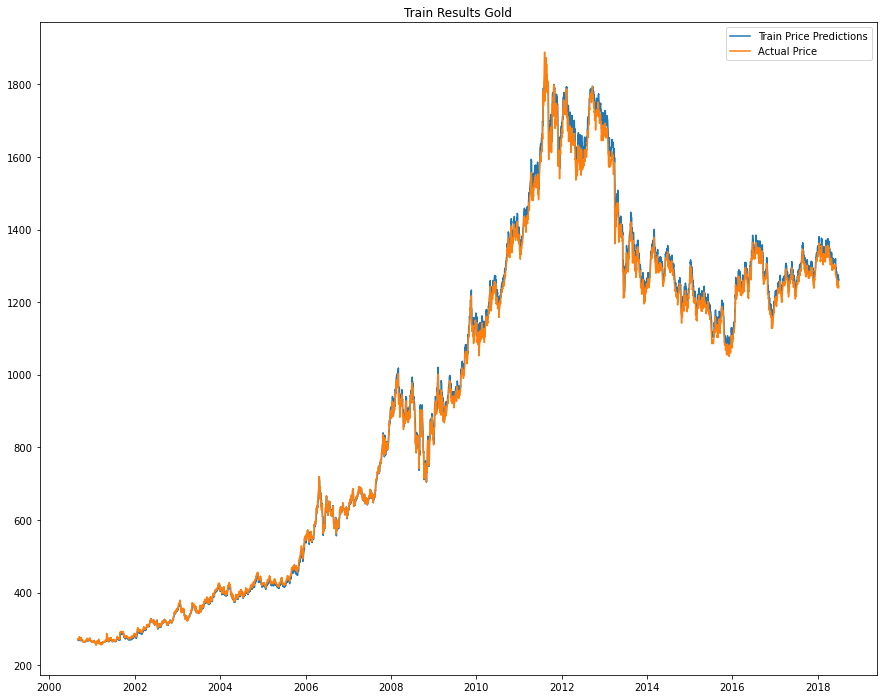

In [224]:
plt.figure(figsize=(15,12))
plt.plot(train_results['Train Predictions'],label = 'Train Price Predictions')
plt.plot(train_results['Actuals'],label = 'Actual Price')
plt.legend()
plt.title("Train Results Gold")
plt.show()

In [225]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1},index=gold_df[4469:5027].index)
val_results

18/18 [==============================] - 0s 7ms/step


,Val Predictions,Actuals
Date,,
2018-06-29,1255.345703,1238.099976
2018-07-02,1255.544678,1225.699951
2018-07-03,1242.070190,1226.300049
2018-07-05,1244.830444,1222.400024
2018-07-06,1239.639771,1229.500000
...,...,...
2020-09-10,1821.588867,1868.300049
2020-09-11,1819.966309,1857.699951
2020-09-14,1818.136230,1872.800049


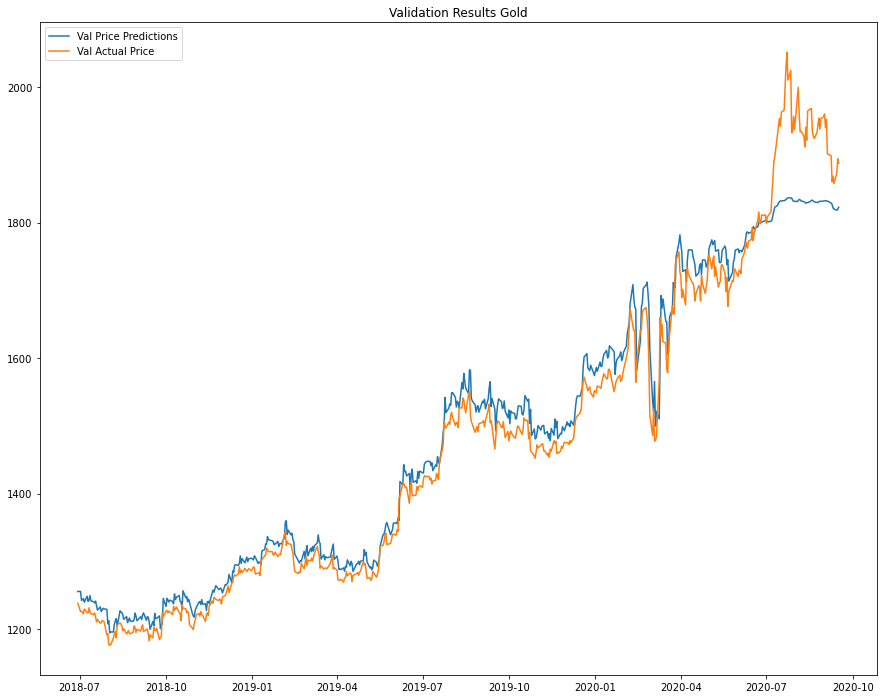

In [226]:
plt.figure(figsize=(15,12))
plt.plot(val_results['Val Predictions'],label = 'Val Price Predictions')
plt.plot(val_results['Actuals'],label = 'Val Actual Price')
plt.title("Validation Results Gold")
plt.legend()


In [229]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1},index=gold_df[5027:5586].index)
test_results

18/18 [==============================] - 0s 7ms/step


,Test Predictions,Actuals
Date,,
2020-09-17,1823.810303,1908.400024
2020-09-18,1826.009766,1900.199951
2020-09-21,1826.375244,1912.500000
2020-09-22,1827.280762,1901.099976
2020-09-23,1826.797607,1883.599976
...,...,...
2022-11-28,1797.567993,1780.500000
2022-11-29,1793.776978,1813.900024
2022-11-30,1800.931519,1807.500000


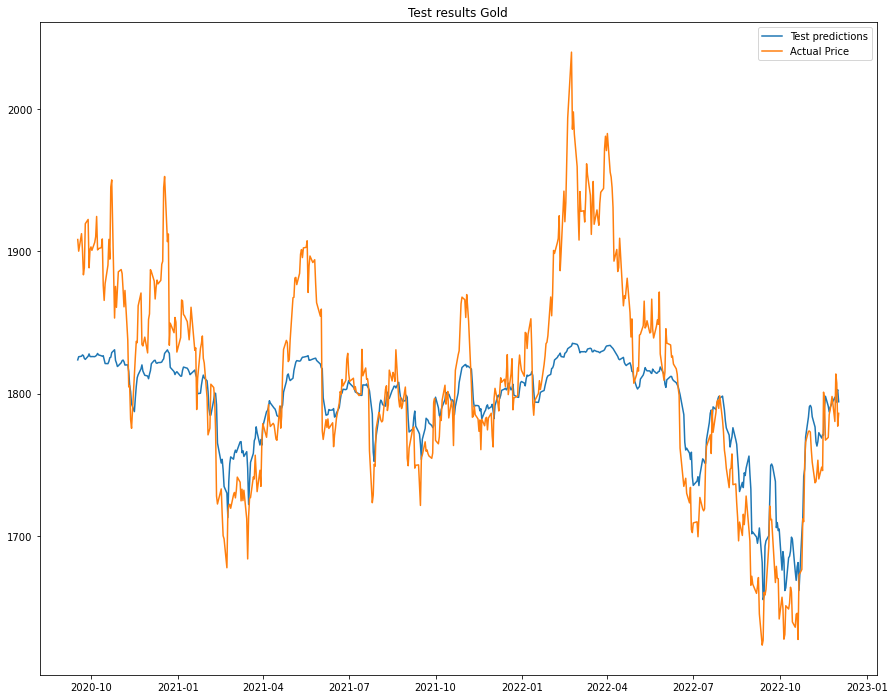

In [231]:
plt.figure(figsize=(15,12))
plt.plot(test_results['Test Predictions'],label='Test predictions')
plt.plot(test_results['Actuals'],label='Actual Price')
plt.legend()
plt.title('Test results Gold')
plt.show()

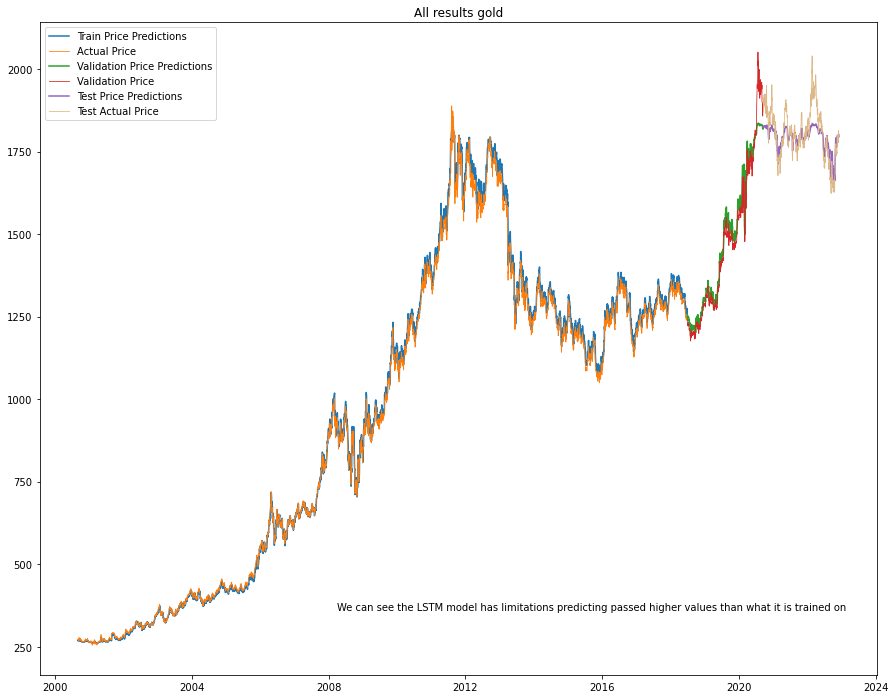

In [232]:


plt.figure(figsize=(15,12))
plt.plot(train_results['Train Predictions'],label = 'Train Price Predictions')
plt.plot(train_results['Actuals'],label = 'Actual Price',linewidth=0.8)
plt.plot(val_results['Val Predictions'],label = 'Validation Price Predictions')
plt.plot(val_results['Actuals'],label = 'Validation Price',linewidth=0.8)
plt.plot(test_results['Test Predictions'],label = 'Test Price Predictions')
plt.plot(test_results['Actuals'],label = 'Test Actual Price',linewidth=0.8,color='burlywood')
plt.title('All results gold')
plt.legend()
plt.figtext(.4, .2,'We can see the LSTM model has limitations predicting passed higher values than what it is trained on')
plt.show()


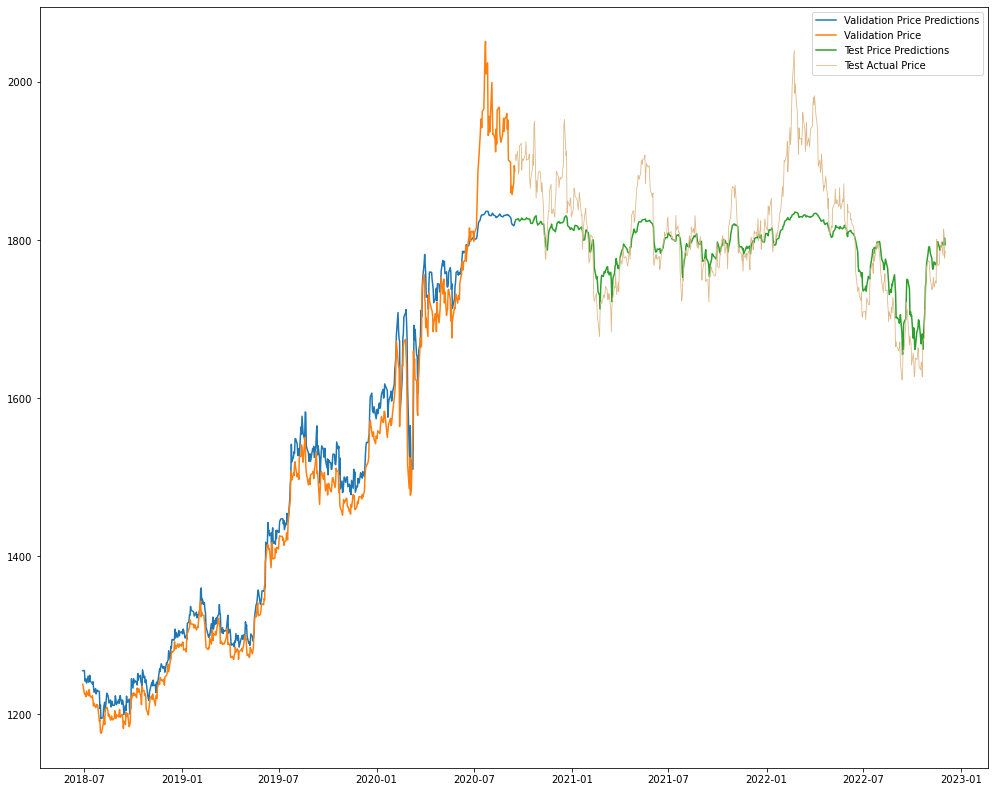

In [233]:
plt.figure(figsize=(17,14))

plt.plot(val_results['Val Predictions'],label = 'Validation Price Predictions')
plt.plot(val_results['Actuals'],label = 'Validation Price')
plt.plot(test_results['Test Predictions'],label = 'Test Price Predictions')
plt.plot(test_results['Actuals'],label = 'Test Actual Price',linewidth=0.8,color='burlywood')
plt.title
plt.legend()
plt.show()



# Model 2 lets change some paramaters to experiment with our Model

#### Based on our findings above the model may to better training on some more recent data including the price range it has come across before amd looking back further in time to predict the next days price(window size under our model

In [234]:
# we can train the model to look back 20 days here to see longer term patterns in training

adj_close = gold_df['Adj Close']
WINDOW_SIZE2 = 20
X2, y2 = df_to_X_y(adj_close, WINDOW_SIZE2)
X2.shape, y2.shape

((5576, 20, 1), (5576,))

In [235]:
##Here the goal is to train the model with some more recent price action
#X2 has 5575 days- we can train up until the end 5000th day and split our validation and test set thereafter

X_train2, y_train2 = X2[:5000], y2[:5000]
X_val2, y_val2 = X2[5000:5392],y2[5000:5392]
X_test2,y_test2 = X2[5392:], y2[5392:]
 
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((5000, 20, 1), (5000,), (392, 20, 1), (392,), (184, 20, 1), (184,))

In [236]:
#we can see how the model performs with double the window size
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(X_train2.shape[1], 1)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 20, 50)            10400     
                                                                 
 lstm_19 (LSTM)              (None, 64)                29440     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 40,369
Trainable params: 40,369
Non-trainable params: 0
_________________________________________________________________


In [237]:
model2.compile(loss= 'mean_squared_error', optimizer='adam')

model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2),epochs=100, batch_size=16)



Epoch 1/100
313/313 [==============================] - 11s 21ms/step - loss: 1141545.8750 - val_loss: 3126613.2500
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 995955.6250 - val_loss: 2777926.2500
Epoch 3/100
313/313 [==============================] - 6s 20ms/step - loss: 797291.5000 - val_loss: 2332718.5000
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 590627.0625 - val_loss: 1869056.1250
Epoch 5/100
313/313 [==============================] - 5s 17ms/step - loss: 419495.0312 - val_loss: 1454237.3750
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 306244.8125 - val_loss: 1134442.3750
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 251041.8906 - val_loss: 964677.3750
Epoch 8/100
313/313 [==============================] - 6s 18ms/step - loss: 225487.5156 - val_loss: 814509.1250
Epoch 9/100
313/313 [==============================] - 5s 17ms/step - loss: 102989.5469 - val_lo

### What is interesting about model 2 is that the train loss is not reduced but the loss of the validation set drops
#### Does this give us better predictive power for our test set??

In [238]:
train_predictions2 = model2.predict(X_train2).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train2},index=gold_df.head(5000).index)
train_results2


157/157 [==============================] - 2s 7ms/step


,Train Predictions,Actuals
Date,,
2000-08-30,273.148895,275.600006
2000-08-31,275.570038,273.600006
2000-09-01,274.102142,273.100006
2000-09-05,273.107300,271.600006
2000-09-06,271.389404,270.299988
...,...,...
2020-08-03,1860.874634,1967.599976
2020-08-04,1873.386719,1968.199951
2020-08-05,1884.195068,1934.400024


In [239]:
val_predictions2= model2.predict(X_val2).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val2},index=gold_df[5000:5392].index)
val_results2




13/13 [==============================] - 0s 6ms/step


,Val Predictions,Actuals
Date,,
2020-08-10,1871.331665,1933.000000
2020-08-11,1869.328247,1944.699951
2020-08-12,1872.424194,1954.199951
2020-08-13,1877.820923,1937.800049
2020-08-14,1878.661011,1953.099976
...,...,...
2022-02-18,1881.780151,1928.599976
2022-02-22,1873.465454,1920.699951
2022-02-23,1864.186157,1936.599976


In [245]:
test_predictions2 = model2.predict(X_test2).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test2},index=gold_df[5392:5576].index)
test_results2


6/6 [==============================] - 0s 10ms/step


,Test Predictions,Actuals
Date,,
2022-02-28,1870.115845,1939.599976
2022-03-01,1868.580688,1912.000000
2022-03-02,1858.746704,1933.500000
2022-03-03,1860.306030,1949.199951
2022-03-04,1868.083252,1919.099976
...,...,...
2022-11-11,1769.643433,1780.500000
2022-11-14,1763.371460,1813.900024
2022-11-15,1779.369507,1807.500000


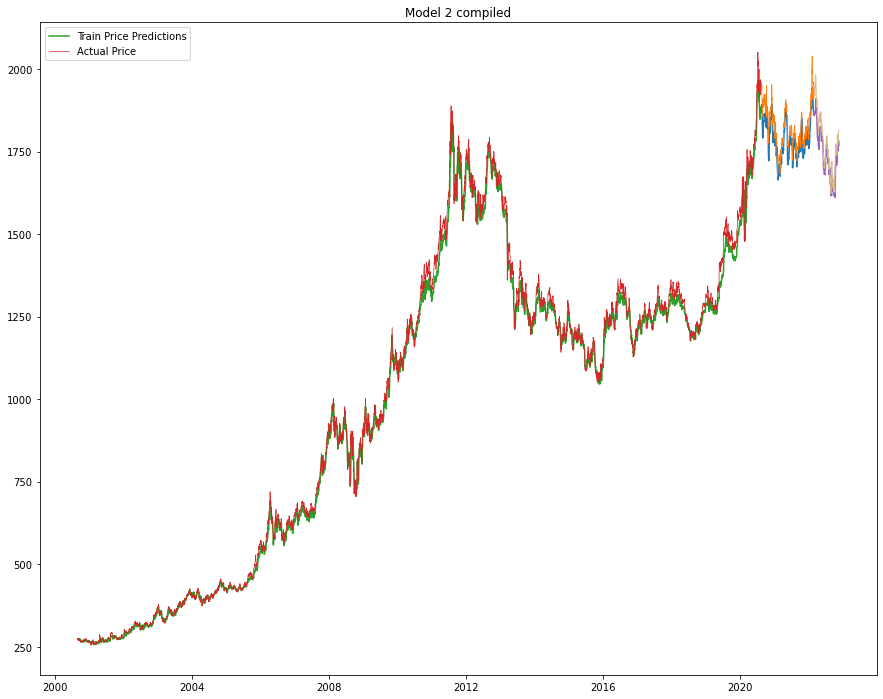

In [247]:
plt.figure(figsize=(15,12))

plt.plot(val_results2['Val Predictions'])
plt.plot(val_results2['Actuals'],linewidth=0.7)
plt.plot(train_results2['Train Predictions'],label = 'Train Price Predictions')
plt.plot(train_results2['Actuals'],label = 'Actual Price',linewidth=0.7)
plt.plot(test_results2['Test Predictions'])
plt.plot(test_results2['Actuals'],linewidth=0.8,color='burlywood')
plt.title('Model 2 compiled')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


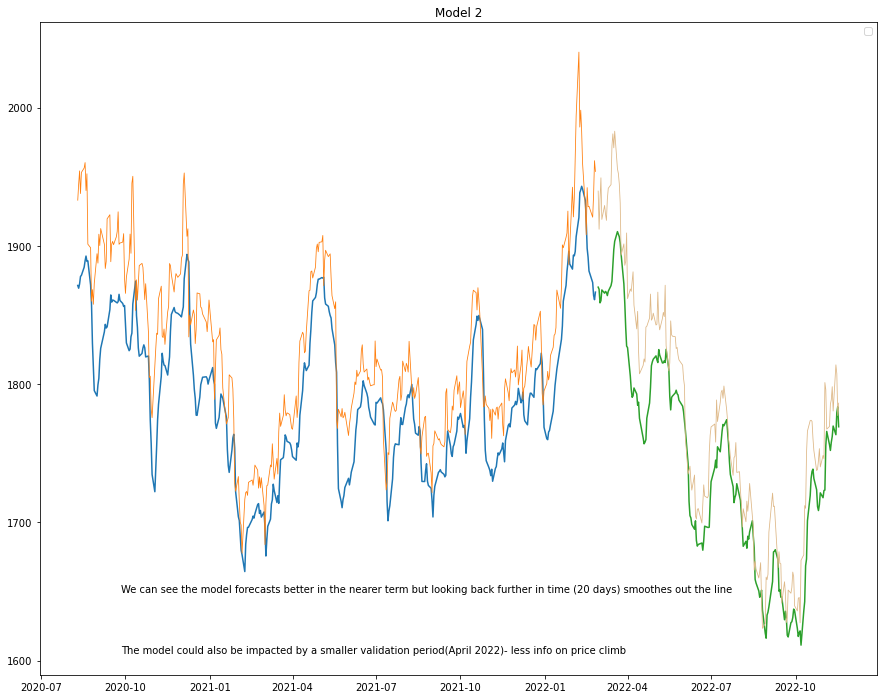

In [248]:
plt.figure(figsize=(15,12))

plt.plot(val_results2['Val Predictions'])
plt.plot(val_results2['Actuals'],linewidth=0.8)

plt.plot(test_results2['Test Predictions'])
plt.plot(test_results2['Actuals'],linewidth=0.8,color='burlywood')
plt.title("Model 2")
plt.legend()
plt.figtext(.2, .15,'The model could also be impacted by a smaller validation period(April 2022)- less info on price climb')
plt.figtext(.2, .22,'We can see the model forecasts better in the nearer term but looking back further in time (20 days) smoothes out the line')


plt.show()

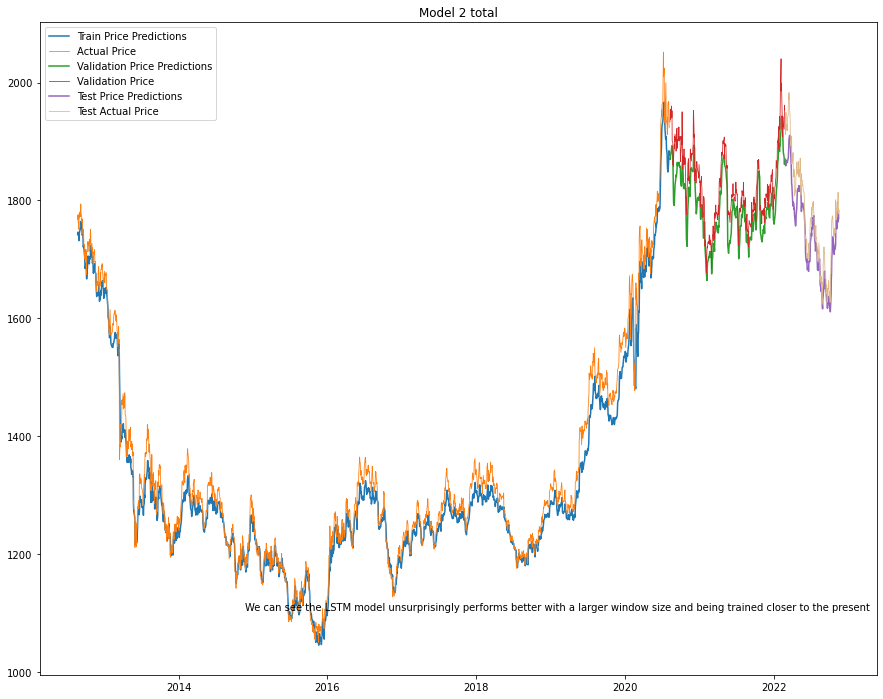

In [249]:
 
plt.figure(figsize=(15,12))
plt.plot(train_results2['Train Predictions'][3000:],label = 'Train Price Predictions')
plt.plot(train_results2['Actuals'][3000:],label = 'Actual Price',linewidth=0.8)
plt.plot(val_results2['Val Predictions'],label = 'Validation Price Predictions')
plt.plot(val_results2['Actuals'],label = 'Validation Price',linewidth=0.8)
plt.plot(test_results2['Test Predictions'],label = 'Test Price Predictions')
plt.plot(test_results2['Actuals'],label = 'Test Actual Price',linewidth=0.8,color='burlywood')
plt.title('Model 2 total')
plt.legend()
plt.figtext(.315, .2,'We can see the LSTM model unsurprisingly performs better with a larger window size and being trained closer to the present')
plt.show()


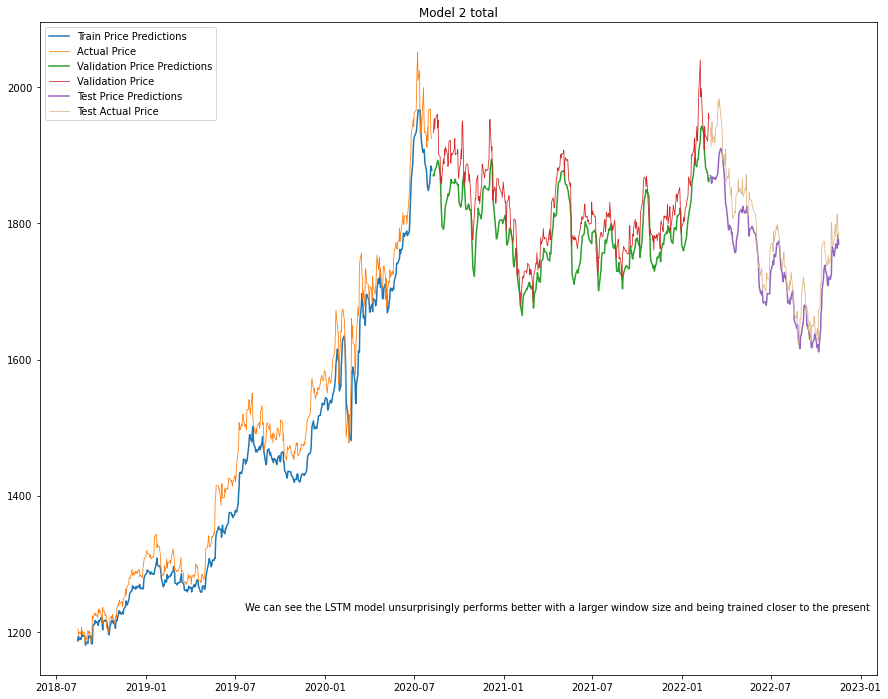

In [250]:
 
  
plt.figure(figsize=(15,12))
plt.plot(train_results2['Train Predictions'][4500:],label = 'Train Price Predictions')
plt.plot(train_results2['Actuals'][4500:],label = 'Actual Price',linewidth=0.8)
plt.plot(val_results2['Val Predictions'],label = 'Validation Price Predictions')
plt.plot(val_results2['Actuals'],label = 'Validation Price',linewidth=0.8)
plt.plot(test_results2['Test Predictions'],label = 'Test Price Predictions')
plt.plot(test_results2['Actuals'],label = 'Test Actual Price',linewidth=0.8,color='burlywood')
plt.title('Model 2 total')
plt.legend()
plt.figtext(.315, .2,'We can see the LSTM model unsurprisingly performs better with a larger window size and being trained closer to the present')
plt.show()


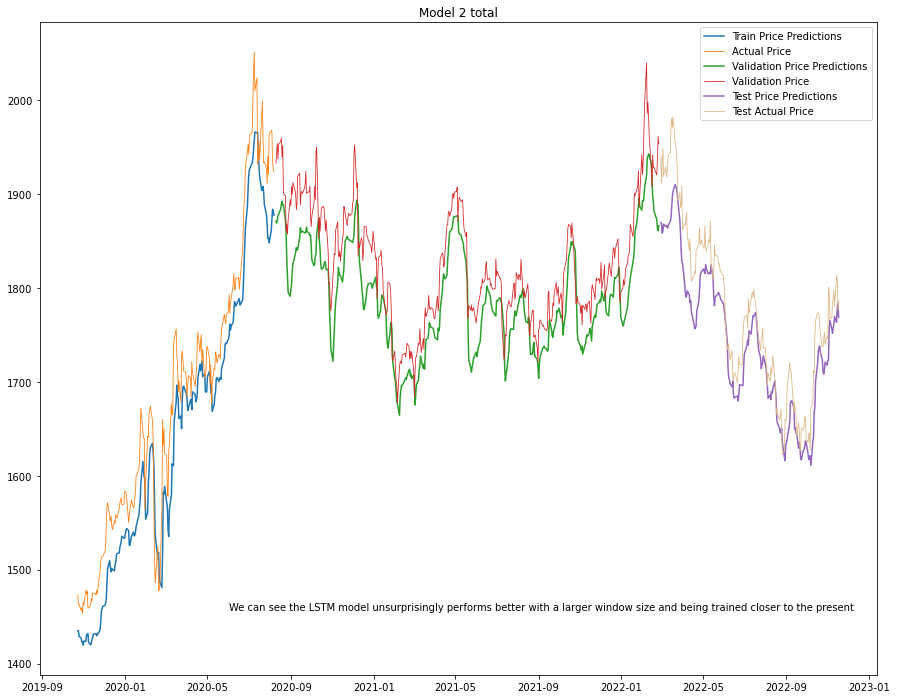

In [251]:
 
  
plt.figure(figsize=(15,12))
plt.plot(train_results2['Train Predictions'][4800:],label = 'Train Price Predictions')
plt.plot(train_results2['Actuals'][4800:],label = 'Actual Price',linewidth=0.8)
plt.plot(val_results2['Val Predictions'],label = 'Validation Price Predictions')
plt.plot(val_results2['Actuals'],label = 'Validation Price',linewidth=0.8)
plt.plot(test_results2['Test Predictions'],label = 'Test Price Predictions')
plt.plot(test_results2['Actuals'],label = 'Test Actual Price',linewidth=0.8,color='burlywood')
plt.title('Model 2 total')
plt.legend()
plt.figtext(.3, .2,'We can see the LSTM model unsurprisingly performs better with a larger window size and being trained closer to the present')
plt.show()


## What have we learned here?
* Using LSTM, time series forecasting models can predict future values based on previous, sequential data. 
* Unsurprisingly, the greater the window size(the further the model looks back to predict the next day) 
  the more accurate the result- though there is a tradeoff here due to overfitting
* Complex LSTM networks perform quite well predicting future prices based on past trends and recent price action
* Howver,the model cannot factor in price peaks well and in a pragmatic sense this may limit their use in algorithmic trading
* These peaks can be due to news events, human emotions-fear/euphoria, price manipulation, liquation events etc.


val_predictions4= model4.predict(X_val1).flatten()
val_results4 = pd.DataFrame(data={'Val Predictions':val_predictions4, 'Actuals':y_val4},index=gold_df[4469:5027].index)
val_results4

# Testing the use of LSTM f orecastingon a more volatile asset, Bitcoin

In [252]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [253]:
start = dt.datetime(2013, 1, 1)
end = dt.datetime.now()

btc_df = web.DataReader("BTC-USD", 'yahoo', start, end)

btc_df = btc_df.drop(['Close','Low','High','Open','Volume'],axis = 1)

btc_df

,Adj Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-12-12,17206.437500
2022-12-13,17781.318359
2022-12-14,17815.650391


### As we can see from initital observation there is a shorter timeseries for this asset while the increase over time seems large.

In [254]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
        
    return np.array(X), np.array(y)

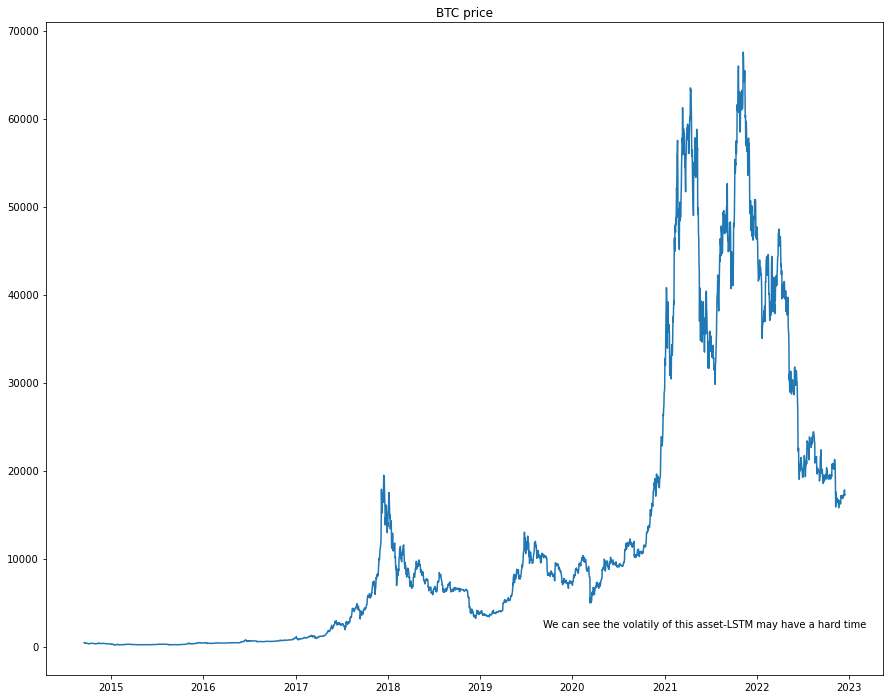

In [255]:
plt.figure(figsize=(15,12))
plt.title('BTC price')
plt.figtext(.585, .18,'We can see the volatily of this asset-LSTM may have a hard time')

plt.plot(btc_df)


In [256]:
adj_close3 = btc_df['Adj Close']
WINDOW_SIZE = 20
X3, y3 = df_to_X_y(adj_close3, WINDOW_SIZE)
X3.shape, y3.shape



((2993, 20, 1), (2993,))

In [257]:
train= len(X3)*0.9
val= train + len(X3)*0.05
train,val

(2693.7000000000003, 2843.3500000000004)

In [258]:


X_train3, y_train3 = X3[800:2200], y3[800:2200]
X_val3, y_val3 = X3[2200:2692],y3[2200:2692]
X_test3,y_test3 = X3[2692:2842], y3[2692:2842]
 
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((1400, 20, 1), (1400,), (492, 20, 1), (492,), (150, 20, 1), (150,))

In [259]:
model3 = Sequential()
model3.add(LSTM(50, return_sequences=True, input_shape=(X_train3.shape[1], 1)))
model3.add(LSTM(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 20, 50)            10400     
                                                                 
 lstm_21 (LSTM)              (None, 64)                29440     
                                                                 
 dense_14 (Dense)            (None, 8)                 520       
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 40,369
Trainable params: 40,369
Non-trainable params: 0
_________________________________________________________________


In [260]:
#I will increase the batch size so our model can go over this more volatile 50% more times in training
model3.compile(loss= 'mean_squared_error', optimizer='adam')

model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3),epochs=100, batch_size=16)

Epoch 1/100
88/88 [==============================] - 12s 64ms/step - loss: 59178916.0000 - val_loss: 1964212736.0000
Epoch 2/100
88/88 [==============================] - 2s 28ms/step - loss: 58991832.0000 - val_loss: 1963054080.0000
Epoch 3/100
88/88 [==============================] - 4s 51ms/step - loss: 58778916.0000 - val_loss: 1961569664.0000
Epoch 4/100
88/88 [==============================] - 4s 45ms/step - loss: 58510968.0000 - val_loss: 1959738880.0000
Epoch 5/100
88/88 [==============================] - 3s 34ms/step - loss: 58185640.0000 - val_loss: 1957533184.0000
Epoch 6/100
88/88 [==============================] - 3s 34ms/step - loss: 57802496.0000 - val_loss: 1954967424.0000
Epoch 7/100
88/88 [==============================] - 4s 50ms/step - loss: 57363028.0000 - val_loss: 1952026496.0000
Epoch 8/100
88/88 [==============================] - 3s 31ms/step - loss: 56868496.0000 - val_loss: 1948749184.0000
Epoch 9/100
88/88 [==============================] - 2s 20ms/step - los

In [261]:
train_predictions3 = model3.predict(X_train3).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3,'Actuals':y_train3},index=btc_df[800:2200].index)
train_results3

44/44 [==============================] - 3s 16ms/step


,Train Predictions,Actuals
Date,,
2016-11-25,6850.233398,778.088013
2016-11-26,6850.233398,784.906982
2016-11-27,6850.233398,790.828979
2016-11-28,6850.233398,790.530029
2016-11-29,6850.233398,792.713989
...,...,...
2020-09-20,6850.233398,11296.361328
2020-09-21,6850.233398,11384.181641
2020-09-22,6850.233398,11555.363281


In [262]:
val_predictions3= model3.predict(X_val3).flatten()
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val3},index=btc_df[2200:2692].index)
val_results3


16/16 [==============================] - 0s 15ms/step


,Val Predictions,Actuals
Date,,
2020-09-25,6850.233398,11495.349609
2020-09-26,6850.233398,11322.123047
2020-09-27,6850.233398,11358.101562
2020-09-28,6850.233398,11483.359375
2020-09-29,6850.233398,11742.037109
...,...,...
2022-01-25,6850.233398,42586.917969
2022-01-26,6850.233398,44575.203125
2022-01-27,6850.233398,43961.859375


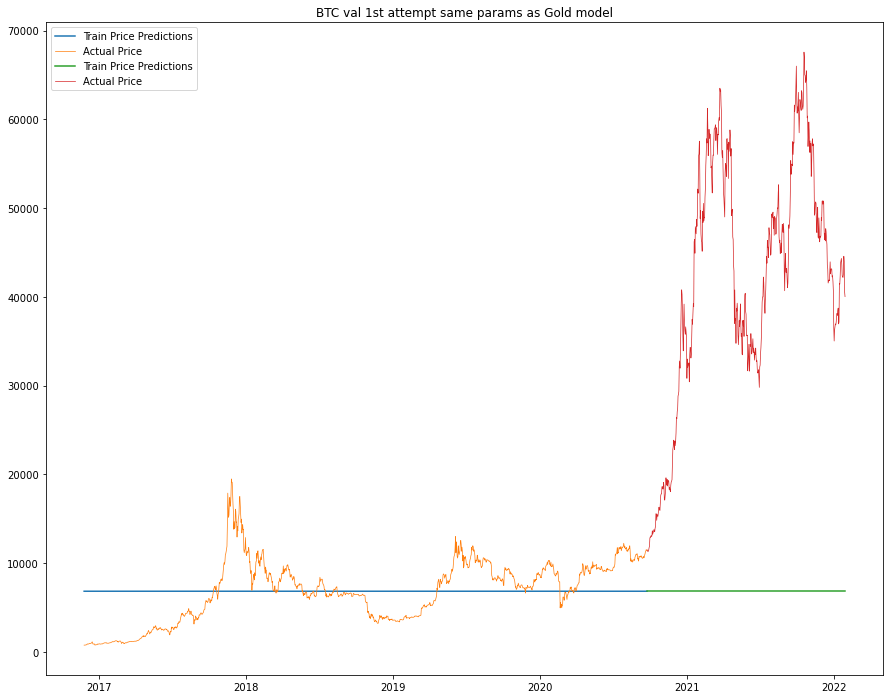

In [263]:
plt.figure(figsize=(15,12))
plt.plot(train_results3['Train Predictions'],label = 'Train Price Predictions')
plt.plot(train_results3['Actuals'],label = 'Actual Price',linewidth=0.7)
plt.plot(val_results3['Val Predictions'],label = 'Train Price Predictions')
plt.plot(val_results3['Actuals'],label = 'Actual Price',linewidth=0.7)
plt.title('BTC val 1st attempt same params as Gold model')
plt.legend()

plt.show()

# Model 4 trying a different approach with data standardization


In [293]:
btc_df

,Adj Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-12-12,17206.437500
2022-12-13,17781.318359
2022-12-14,17815.650391


In [323]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [295]:

##splitting dataset into train and test split
train_size=int(len(btc_df)*0.85)

test_size=len(btc_df)-train_size

train_size,test_size




(2561, 452)

In [298]:
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]
train_data,test_data

(array([[0.00414359],
        [0.00365546],
        [0.00321557],
        ...,
        [0.71377312],
        [0.69866459],
        [0.63312813]]),
 array([[0.60122183],
        [0.6439713 ],
        [0.6635679 ],
        [0.63306802],
        [0.63124047],
        [0.63854059],
        [0.62410481],
        [0.60628005],
        [0.61414221],
        [0.64718232],
        [0.71137773],
        [0.7053611 ],
        [0.71260957],
        [0.72615707],
        [0.76179968],
        [0.81888099],
        [0.79579902],
        [0.79820095],
        [0.8130458 ],
        [0.81012773],
        [0.85038982],
        [0.82896591],
        [0.8491479 ],
        [0.84796708],
        [0.91136679],
        [0.90095304],
        [0.91076829],
        [0.91777927],
        [0.95095862],
        [0.97664309],
        [0.92051109],
        [0.89798646],
        [0.90839401],
        [0.90152667],
        [0.93282253],
        [0.89311216],
        [0.86519345],
        [0.8969458 ],
        [0.920775

In [297]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, window_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window_size-1):
        a = dataset[i:(i+window_size), 0]   
        dataX.append(a)
        dataY.append(dataset[i + window_size, 0])
    return np.array(dataX), np.array(dataY)

In [299]:
 window_size= 7
X_train, y_train = create_dataset(train_data, window_size)
X_test, y_test = create_dataset(test_data, window_size)
X_train.shape, y_train.shape,X_test.shape,y_test.shape

((2553, 7), (2553,), (444, 7), (444,))

In [300]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_test.shape,y_test.shape,

((444, 7, 1), (444,))

In [301]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(window_size,1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()



Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 7, 50)             10400     
                                                                 
 lstm_33 (LSTM)              (None, 64)                29440     
                                                                 
 dense_22 (Dense)            (None, 8)                 520       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 40,369
Trainable params: 40,369
Non-trainable params: 0
_________________________________________________________________


In [303]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=8)

Epoch 1/100
320/320 [==============================] - 5s 17ms/step - loss: 5.5426e-04 - val_loss: 0.0020
Epoch 2/100
320/320 [==============================] - 5s 16ms/step - loss: 6.0309e-04 - val_loss: 0.0016
Epoch 3/100
320/320 [==============================] - 4s 12ms/step - loss: 6.2422e-04 - val_loss: 0.0013
Epoch 4/100
320/320 [==============================] - 4s 12ms/step - loss: 5.4763e-04 - val_loss: 0.0015
Epoch 5/100
320/320 [==============================] - 4s 12ms/step - loss: 5.0617e-04 - val_loss: 0.0014
Epoch 6/100
320/320 [==============================] - 4s 13ms/step - loss: 3.9823e-04 - val_loss: 0.0015
Epoch 7/100
320/320 [==============================] - 4s 13ms/step - loss: 4.2030e-04 - val_loss: 0.0019
Epoch 8/100
320/320 [==============================] - 4s 14ms/step - loss: 3.7501e-04 - val_loss: 0.0018
Epoch 9/100
320/320 [==============================] - 4s 13ms/step - loss: 3.8875e-04 - val_loss: 0.0011
Epoch 10/100
320/320 [========================

In [319]:
train_pred4 = model.predict(X_train)
train_pred4


80/80 [==============================] - 0s 6ms/step


array([[0.00256081],
       [0.0025318 ],
       [0.00253571],
       ...,
       [0.7004466 ],
       [0.6904387 ],
       [0.6993995 ]], dtype=float32)

In [324]:

scale = preprocessing.MinMaxScaler()
train_predict= scale.inverse_transform(train_pred4)
train_predict

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [307]:
#2259, 753
train_df=pd.DataFrame(train_predict,index=btc_df[:2553].index)
train_df

,0
Date,
2014-09-17,0.002561
2014-09-18,0.002532
2014-09-19,0.002536
2014-09-20,0.002523
2014-09-21,0.002525
...,...
2021-09-08,0.683058
2021-09-09,0.702554
2021-09-10,0.700447


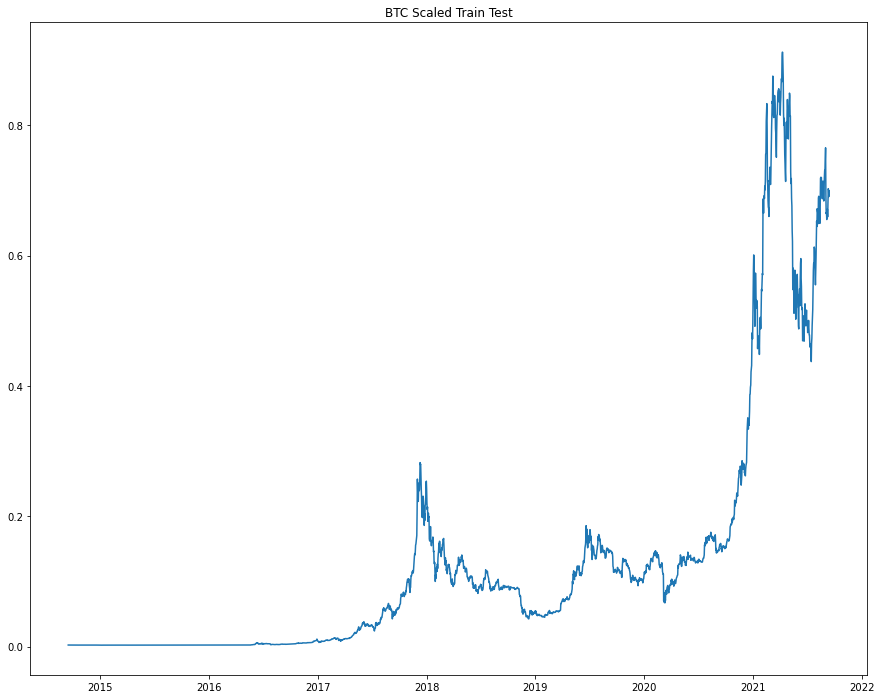

In [315]:
plt.figure(figsize=(15,12))
plt.title('BTC Scaled Train Test')
plt.plot(train_df)

In [309]:
#2259, 753
test_predictions4 = model.predict(X_test)
test_results4 = scaler.inverse_transform(test_predictions4)

test_results4


14/14 [==============================] - 0s 7ms/step


array([[0.6170944 ],
       [0.60073596],
       [0.6038279 ],
       [0.6350697 ],
       [0.6998593 ],
       [0.7056762 ],
       [0.7054152 ],
       [0.7119657 ],
       [0.74422395],
       [0.8009428 ],
       [0.7919082 ],
       [0.78356194],
       [0.79145896],
       [0.79351205],
       [0.8277184 ],
       [0.8186203 ],
       [0.8281982 ],
       [0.82946736],
       [0.8803293 ],
       [0.88521576],
       [0.8883716 ],
       [0.8909645 ],
       [0.91736627],
       [0.94476175],
       [0.9063602 ],
       [0.872543  ],
       [0.8740189 ],
       [0.87644815],
       [0.9039787 ],
       [0.8796243 ],
       [0.84656274],
       [0.86346614],
       [0.8929899 ],
       [0.8971715 ],
       [0.8868933 ],
       [0.8772192 ],
       [0.90182555],
       [0.9083296 ],
       [0.8899704 ],
       [0.87835187],
       [0.8816043 ],
       [0.9064871 ],
       [0.96254414],
       [0.9668336 ],
       [0.9378027 ],
       [0.9250761 ],
       [0.9164665 ],
       [0.921

In [326]:
test_df=pd.DataFrame(test_results4,index=btc_df[2553:].index)

test_df


ValueError: Shape of passed values is (444, 1), indices imply (460, 1)

""
Date


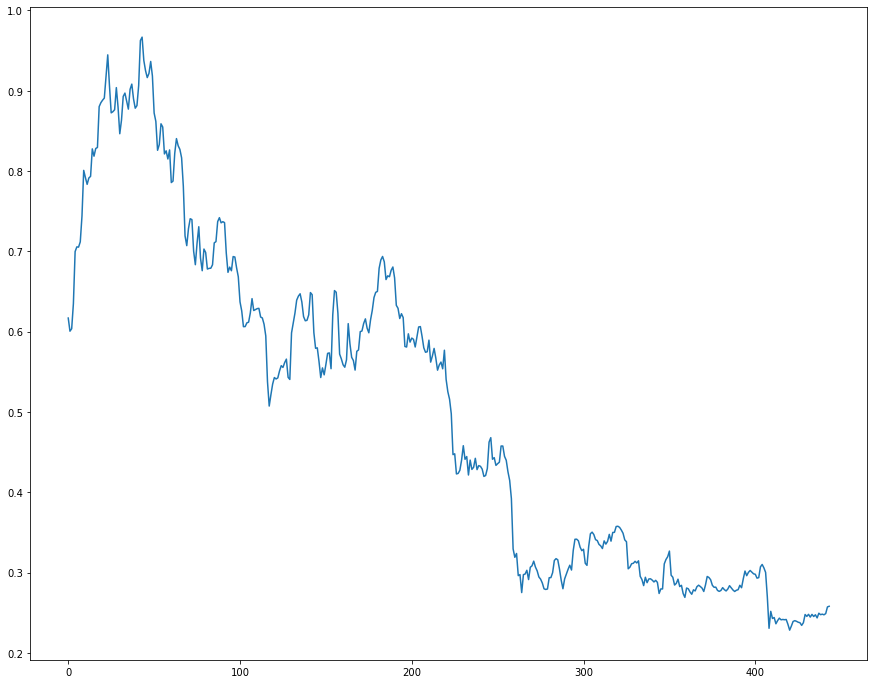

In [314]:
plt.figure(figsize=(15,12))
plt.plot(test_df,)